In [1]:
import os 
import xarray as xr
import numpy as np 
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import scipy.fftpack as fp
import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime 

from dask import delayed,compute

import pyinterp.backends.xarray
import pyinterp.fill

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import cmocean

import glob 

## Load data

The data is loaded from the folder MIT_gcm_filtered_final, which contains all the filtered variables.  

In [2]:
path05 = "/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_201205*.nc"
path06 = "/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_201206*.nc"
path07 = "/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_201207*.nc"

path = np.sort(np.concatenate([glob.glob(path05),glob.glob(path06),glob.glob(path07)]))

ds_ssh = xr.open_mfdataset(path, combine="nested",concat_dim="time")
#ds_ssh

KeyboardInterrupt: 

In [ ]:
ds_ssh = xr.open_mfdataset(["/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120604.nc",
                            "/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120605.nc"],combine='nested',concat_dim='time')

In [ ]:
ds_ssh = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120604.nc")
ds_ssh_bis = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120501.nc")

The CCS region is selected : 

In [ ]:
ds_ssh = ds_ssh.sel(longitude=slice(230,240),latitude=slice(30,40))
#ds_ssh = ds_ssh.sel(time=slice(np.datetime64("2012-05-01"),np.datetime64("2012-05-10")))
#ds_ssh

In [ ]:

mask = np.load("/bettik/bellemva/MITgcm/mask/mask_MITgcm.npy")

In [ ]:
ssh_bm = ds_ssh.ssh_bm[12].values
ssh_bar_600 = ds_ssh.ssh_bar_600[12].values
ssh_igw = ds_ssh.ssh_igw[12].values
ssh_cor = ds_ssh.ssh_cor[12].values

ssh_bm[mask]=np.nan
ssh_bar_600[mask]=np.nan
ssh_igw[mask]=np.nan
ssh_cor[mask]=np.nan


In [ ]:
plt.figure()
plt.pcolormesh(ds_ssh_bis.ssh_dedac[12].values,vmin=-1,vmax=1,cmap='RdBu')
plt.xlim(2500,3100)
plt.ylim(800,1600)

plt.figure()
plt.pcolormesh(ds_ssh.ssh_dedac[12].values,vmin=-1,vmax=1,cmap='RdBu')
plt.xlim(2500,3100)
plt.ylim(800,1600)

In [ ]:
plt.pcolormesh(ds_ssh.longitude.values, ds_ssh.latitude.values,mask)
plt.xlim(230,240)
plt.ylim(30,40)

In [ ]:
plt.pcolormesh(ds_ssh.longitude.values, ds_ssh.latitude.values,ssh_bar_600)
plt.xlim(230,240)
plt.ylim(30,40)

In [ ]:
ssh_test[mask]=np.nan

In [ ]:
plt.pcolormesh(ds_ssh.longitude.values, ds_ssh.latitude.values,mask)
plt.xlim(230,240)
plt.ylim(30,40)


In [ ]:
import pyinterp.backends.xarray
import pyinterp.fill

x_axis = pyinterp.Axis(ds_ssh.longitude.values)
y_axis = pyinterp.Axis(ds_ssh.latitude.values)

has_converged, filled = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ssh_test.T))


In [ ]:
ssh_test_filled = filled.T
ssh_test_filled[mask]=np.nan

In [ ]:
plt.pcolormesh(ds_ssh.longitude.values, ds_ssh.latitude.values,ssh_test_filled)
plt.xlim(230,240)
plt.ylim(30,40)


In [ ]:
plt.pcolormesh(ds_ssh.ssh_bar_600.values[200])
plt.xlim(230,240)
plt.ylim(30,40)


In [ ]:
longitude = ds_ssh.longitude.values
latitude = ds_ssh.latitude.values
time= ds_ssh.time.values
ny = latitude.size
nx = longitude.size
nt = time.size


In [ ]:
def gaspari_cohn(r,c):

    if type(r) is float or type(r) is int:
        ra = np.array([r])
    else:
        ra = r
    if c<=0:
        return np.zeros_like(ra)
    else:
        ra = 2*np.abs(ra)/c
        gp = np.zeros_like(ra)
        i= np.where(ra<=1.)[0]
        gp[i]=-0.25*ra[i]**5+0.5*ra[i]**4+0.625*ra[i]**3-5./3.*ra[i]**2+1.
        i =np.where((ra>1.)*(ra<=2.))[0]
        gp[i] = 1./12.*ra[i]**5-0.5*ra[i]**4+0.625*ra[i]**3+5./3.*ra[i]**2-5.*ra[i]+4.-2./3./ra[i]
        if type(r) is float:
            gp = gp[0]
    return gp

In [ ]:
array_ssh = ds_ssh.ssh_igw.values

In [ ]:
nt = ds_ssh.time.size

dt = 3600 # seconds
 
w = fp.fftfreq(3*nt,dt)# seconds^-1

w1 = 1/15/3600
w2 = 1/9/3600
H = (np.abs(w)>w1) & (np.abs(w)<w2)

wint = np.ones(3*nt)
wint[:nt] = gaspari_cohn(np.arange(0,nt,1),nt)[::-1]
wint[2*nt:] = gaspari_cohn(np.arange(0,nt),nt)
    
def compute_band_pass(ssh,H):
    ssh_extended = np.zeros((3*nt,))
    ssh_extended[nt:2*nt] = ssh
    ssh_extended[:nt] = ssh[::-1]
    ssh_extended[2*nt:] = ssh[::-1]

    ssh_win = wint * ssh_extended 
    ssh_f_t = fp.fft(ssh_win)
    ssh_f_filtered =  H * ssh_f_t
    ssh_filtered = np.real(fp.ifft(ssh_f_filtered))[nt:2*nt]
    return ssh_filtered

array_ssh_it=np.empty_like(array_ssh,dtype='float64')
for i in range (0,array_ssh.shape[1]): 
    for j in range(0,array_ssh.shape[2]):
        array_ssh_it[:,i,j]=compute_band_pass(array_ssh[:,i,j],H)


In [ ]:
plt.pcolormesh(array_ssh_it[40,:,:],vmin=-0.1,vmax=0.1,cmap='RdBu')

## Extract internal tides spatial modes

In [ ]:
lon = ds_ssh.longitude.values
lat = ds_ssh.latitude.values

ny = lat.size
nx = lon.size

def lonlat2dxdy(lon,lat):
    dlon = np.gradient(lon)
    dlat = np.gradient(lat)
    dx = np.sqrt((dlon[1]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[1]*111000)**2)
    dy = np.sqrt((dlon[0]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[0]*111000)**2)
    dx[0,:] = dx[1,:]
    dx[-1,: ]= dx[-2,:] 
    dx[:,0] = dx[:,1]
    dx[:,-1] = dx[:,-2]
    dy[0,:] = dy[1,:]
    dy[-1,:] = dy[-2,:] 
    dy[:,0] = dy[:,1]
    dy[:,-1] = dy[:,-2]
    return dx,dy


lon2d,lat2d = np.meshgrid(lon,lat)
dx,dy = lonlat2dxdy(lon2d,lat2d)
dx0 = dx.mean()
dy0 = dy.mean()

kx = np.fft.fftfreq(3*nx,dx0*1e-3) # km
ky = np.fft.fftfreq(3*ny,dy0*1e-3) # km
k, l = np.meshgrid(kx,ky)
wavnum2D = np.sqrt(k**2 + l**2)

k1 = 0.0070
k2 = 0.0126
k3 = 0.0191
k4 = 0.0269



## Spatial window
winy = np.ones(3*ny)
winy[:ny] = gaspari_cohn(np.arange(0,ny,1),ny)[::-1]
winy[2*ny:] = gaspari_cohn(np.arange(0,ny),ny)

winx = np.ones(3*nx)
winx[:nx] = gaspari_cohn(np.arange(0,nx,1),nx)[::-1]
winx[2*nx:] = gaspari_cohn(np.arange(0,nx),nx)

window = winy[:,np.newaxis] * winx[np.newaxis,:]

kernel = Gaussian2DKernel(x_stddev=6)

In [ ]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended


def apply_filter(ssh_freq,H):
    ssh_freq_filtered = H * ssh_freq
    ssh_filtered = np.real(fp.ifft2(ssh_freq_filtered))
    return ssh_filtered

def bandpass(wavenumbers):
    _bandpass = np.zeros((3*ny,3*nx))
    for i in range(3*ny):
        for j in range(3*nx):
            if wavnum2D[i,j]>wavenumbers[0] and wavnum2D[i,j]<wavenumbers[1]:
                _bandpass[i,j] = 1
    return _bandpass

def interpolate_nans(_ds):
    has_converged, filled = pyinterp.fill.gauss_seidel(_ds)
    if has_converged :
        return filled.T
    else : 
        "Pyinterp hasn't converged"
        raise Exception



wavenumbers_mode_1 = [0.5*k1,0.5*(k1+k2)] # in km
wavenumbers_mode_2 = [0.5*(k1+k2),0.5*(k2+k3)] # in km
wavenumbers_mode_3 = [0.5*(k2+k3),0.5*(k3+k4)] # in km

bandpass_mode_1 = bandpass(wavenumbers_mode_1)
bandpass_mode_2 = bandpass(wavenumbers_mode_2)
bandpass_mode_3 = bandpass(wavenumbers_mode_3)



In [ ]:
ssh0 = array_ssh_it[30,:,:]

mask = np.isnan(ssh0)

# Remove nans
lon_axis = pyinterp.Axis(lon)
lat_axis = pyinterp.Axis(lat)

ssh_noNans = interpolate_nans(pyinterp.Grid2D(lon_axis, lat_axis, ssh0.T))

# Extend
ssh_extended = extend(ssh_noNans,nx,ny) 
#ssh_extended[np.abs(ssh_extended)>0.1] = np.nan



# Windowing
ssh_win = ssh_extended * window

# FFT
ssh_freq = fp.fft2(ssh_win)

# Filter
_ssh_1_np = apply_filter(ssh_freq, bandpass_mode_1)[ny:2*ny,nx:2*nx]
_ssh_2_np = apply_filter(ssh_freq, bandpass_mode_2)[ny:2*ny,nx:2*nx]
_ssh_3_np = apply_filter(ssh_freq, bandpass_mode_3)[ny:2*ny,nx:2*nx]

# Mask
_ssh_1_np[mask] = np.nan
_ssh_2_np[mask] = np.nan
_ssh_3_np[mask] = np.nan


In [5]:
ds_ssh = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_it/by_mode/CCS_snapshot.nc")
ds_ssh

<xarray.Dataset>
Dimensions:    (latitude: 481, longitude: 481, time: 24)
Coordinates:
  * latitude   (latitude) float32 30.0 30.02 30.04 30.06 ... 39.96 39.98 40.0
  * longitude  (longitude) float32 230.0 230.0 230.0 230.1 ... 240.0 240.0 240.0
  * time       (time) datetime64[ns] 2012-06-05 ... 2012-06-05T23:00:00
Data variables:
    ssh_it1    (time, latitude, longitude) float64 ...
    ssh_it2    (time, latitude, longitude) float64 ...
    ssh_it3    (time, latitude, longitude) float64 ...

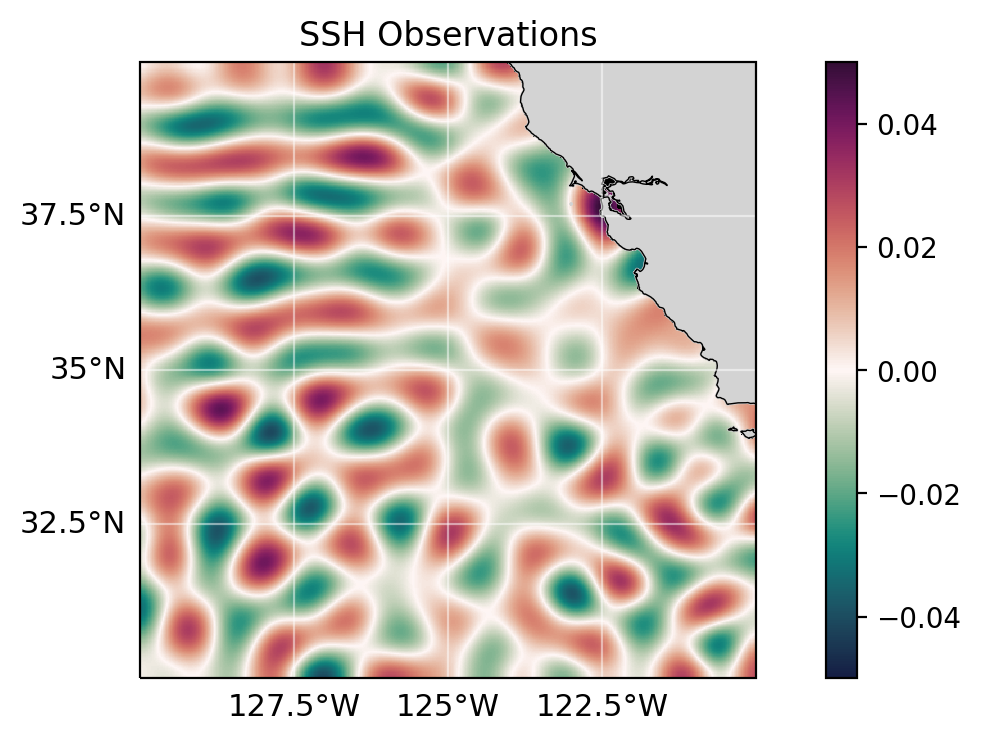

In [6]:
### PLOT FOR LIEGE POSTER ### 

fig, ax = plt.subplots(figsize=(9,4),dpi=200,subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0.)})

ax.set_extent([-130, -120,30, 40],crs=ccrs.PlateCarree())

map_ssh = ax.pcolormesh(ds_ssh.longitude.values,
            ds_ssh.latitude.values,
            #_ssh_1_np,
            ds_ssh.ssh_it1[16].values,
            vmin=-0.05,vmax =0.05,
            cmap=cmocean.cm.curl,
            )


ax.add_feature(cfeature.LAND,color="lightgrey",zorder=1)
ax.add_feature(cfeature.OCEAN,color="black",zorder=0)
ax.coastlines(lw=0.5)
ax.set_aspect("equal")
ax.set_title("SSH Observations")

gridlines = ax.gridlines(
    alpha=0.5,
    color="white",
    draw_labels=True,
    xlocs=np.arange(-180,-115,2.5),
    ylocs=np.arange(10,45,2.5),
    # xformatter=cartopy.mpl.ticker.LongitudeFormatter(zero_direction_label=True,),
)
gridlines.right_labels = False
gridlines.top_labels  = False
gridlines.xlabel_style = {'size': 11}
gridlines.ylabel_style = {'size': 11}
ax.set_aspect("equal")

cbar = plt.colorbar(mappable=map_ssh)


In [ ]:
frame_per_files = 1
import gc
def create_dataset(t0,path):
    _nt = min(frame_per_files,nt-t0)
    shapeout = (_nt,lat.size,lon.size)
    _ssh = ssh_it_12h.isel(time=slice(t0,t0+_nt))
    _ssh_1 = xr.DataArray(np.empty(shapeout), dims=['time','lat','lon'])
    _ssh_2 = xr.DataArray(np.empty(shapeout), dims=['time','lat','lon'])
    _ssh_3 = xr.DataArray(np.empty(shapeout), dims=['time','lat','lon'])
    
    for i in range(_nt):
        ssh0 = ssh_it_12h[t0+i].values
        mask = np.isnan(ssh0)
        
        # Extend
        ssh_extended = extend(ssh0)
        ssh_extended[np.abs(ssh_extended)>0.1] = np.nan
        
        # Remove nans
        ssh_extended_noNans = interpolate_replace_nans(ssh_extended, kernel)
        
        # Windowing
        ssh_win = ssh_extended_noNans * window
        
        # FFT
        ssh_freq = fp.fft2(ssh_win)
        
        # Filter
        _ssh_1_np = apply_filter(ssh_freq, bandpass_mode_1)[ny:2*ny,nx:2*nx]
        _ssh_2_np = apply_filter(ssh_freq, bandpass_mode_2)[ny:2*ny,nx:2*nx]
        _ssh_3_np = apply_filter(ssh_freq, bandpass_mode_3)[ny:2*ny,nx:2*nx]
        
        # Mask
        _ssh_1_np[mask] = np.nan
        _ssh_2_np[mask] = np.nan
        _ssh_3_np[mask] = np.nan
        
        # Fill array
        _ssh_1[i] = _ssh_1_np
        _ssh_2[i] = _ssh_2_np
        _ssh_3[i] = _ssh_3_np
        
    dsout = xr.Dataset({'ssh_it':(('time','lat','lon'),_ssh.data),
                        'ssh_it_1':(('time','lat','lon'),_ssh_1.data),
                        'ssh_it_2':(('time','lat','lon'),_ssh_2.data),
                        'ssh_it_3':(('time','lat','lon'),_ssh_3.data),
                       },
                       coords={'time':('time',time[t0:t0+_nt]),'lat':('lat',lat),'lon':('lon',lon)}
                      )
    dsout.to_netcdf(path)
    
    dsout.close()
    del dsout
    
    del _ssh,_ssh_1,_ssh_2,_ssh_3,ssh0,_ssh_1_np,_ssh_2_np,_ssh_3_np,mask,ssh_freq,ssh_win,ssh_extended_noNans,ssh_extended
    gc.collect()
    
    return path

In [ ]:
time_save = np.arange(0,nt,frame_per_files)

def create_filepath(date, prefix='ssh_it', root_path=dir_data):
    filepath = f'{root_path}/{prefix}_{date}.nc'
    return filepath

dates = [pd.to_datetime(str(ds.time.data[t])).strftime("%Y-%m-%d_%H") for t in time_save]
paths = [create_filepath(date) for date in dates]


In [ ]:
create_dataset(time_save[0],paths[0])

In [ ]:
from dask import delayed,compute
delayed_results = []
for t0,path in zip(time_save,paths):
    res = delayed(create_dataset)(t0, path)
    delayed_results.append(res)
results = compute(*delayed_results, scheduler="processes")

In [ ]:
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120605.nc")
ssh_bm = ds.ssh_bm
ssh_bm = ssh_bm.sel(longitude=slice(230,240),latitude=slice(30,40))


In [ ]:
ssh_bm

In [ ]:
### SSH BM FOR LIEGE POSTER ### 

### PLOT FOR LIEGE POSTER ### 

fig, ax = plt.subplots(figsize=(9,4),dpi=200,subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0.)})

ax.set_extent([-130, -120,30, 40],crs=ccrs.PlateCarree())

map_ssh = ax.pcolormesh(ds_ssh.longitude.values,
            ds_ssh.latitude.values,
            #_ssh_1_np,
            ssh_bm[16].values,
            vmin=0.2,vmax =0.6,
            cmap="Blues",
            )


ax.add_feature(cfeature.LAND,color="lightgrey",zorder=1)
ax.add_feature(cfeature.OCEAN,color="black",zorder=0)
ax.coastlines(lw=0.5)
ax.set_aspect("equal")
ax.set_title("SSH Observations")

gridlines = ax.gridlines(
    alpha=0.5,
    color="white",
    draw_labels=True,
    xlocs=np.arange(-180,-115,2.5),
    ylocs=np.arange(10,45,2.5),
    # xformatter=cartopy.mpl.ticker.LongitudeFormatter(zero_direction_label=True,),
)
gridlines.right_labels = False
gridlines.top_labels  = False
gridlines.xlabel_style = {'size': 11}
gridlines.ylabel_style = {'size': 11}
ax.set_aspect("equal")

cbar = plt.colorbar(mappable=map_ssh)


In [ ]:
plt.hist(ssh_bm[16].values.flatten())